i,key 0 plot1
runtodo m11bcr_700
rundir /m11b/cr_700/
loading file : /home/tkc004//oasis/philruns///m11b/cr_700///output//snapshot_500.hdf5
npart_file:  [12710287 12771424 19289221        0    61146        0]
npart_total: [12710287 12771424 19289221        0    61146        0]
flag_cooling 1
this time 0.8550954952188655
hubble 0.702
atime 0.8550954952188655
loading file : /home/tkc004//oasis/philruns///m11b/cr_700///output//snapshot_500.hdf5
npart_file:  [12710287 12771424 19289221        0    61146        0]
npart_total: [12710287 12771424 19289221        0    61146        0]
flag_cooling 1
xvcen, yvcen, zvcen -212.04895121590187 -325.3408064420092 -223.02837858362955
Gvx,Gvy,Gvz 1.3081478232473391 8.992113523685465 -10.372255772506644
loading file : /home/tkc004//oasis/philruns///m11b/cr_700///output//snapshot_500.hdf5
npart_file:  [12710287 12771424 19289221        0    61146        0]
npart_total: [12710287 12771424 19289221        0    61146        0]
flag_cooling 1
this time 0.85

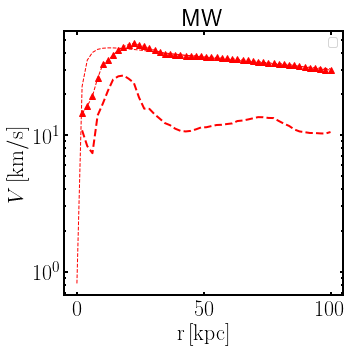

In [21]:
from stdmodandoption import *
import plot_setup as PS
import collections
from calreffdis_tools import calreff


def calVth(G,rmin=0.1,rmax=50.,num=50,cutangle=45.): #anglecut is the opening angle cut in degree
    rlist=np.linspace(rmin,rmax,num=num)
    Vthlist=np.array([])
    Gpos = G['p'][:,:]; Gmass = G['m'][:]; Gu = G['u'][:]; 
    Grho = G['rho'][:];
    Gx = Gpos[:,0]; Gy = Gpos[:,1]; Gz = Gpos[:,2]
    Gr = np.sqrt(np.square(Gx)+np.square(Gy)+np.square(Gz))
    angle = np.arccos(np.absolute(Gz)/Gr)
    anglecut = angle/np.pi*180.<45.    
    for i in range(len(rlist)-1):
        withinrlist = (Gr<rlist[i+1])*(Gr>rlist[i])
        cut= withinrlist*anglecut
        Gmcut = Gmass[cut]
        Grhocut = Grho[cut]
        Gucut = Gu[cut]
        Guave = np.average(Gucut,weights=Gmcut/Grhocut)
        Vthlist = np.append(Vthlist,np.sqrt(GAMMA*(GAMMA-1.)*Guave))
    return {'Vthlist':Vthlist, 'rlist':rlist}


def calVgas(G,rmin=0.1,rmax=50.,num=50,cutangle=45.):
    rlist=np.linspace(rmin,rmax,num=num)
    Gvrlist=np.array([])
    Gpos = G['p'][:,:]; Gmass = G['m'][:]; Gv = G['v'][:,:]; 
    Grho = G['rho'][:];
    Gx = Gpos[:,0]; Gy = Gpos[:,1]; Gz = Gpos[:,2]
    Gvx = Gv[:,0]; Gvy = Gv[:,1]; Gvz = Gv[:,2]
    Gr = np.sqrt(np.square(Gx)+np.square(Gy)+np.square(Gz))
    Gvr = (Gvx*Gx+Gvy*Gy+Gvz*Gz)/Gr
    angle = np.arccos(np.absolute(Gz)/Gr)
    anglecut = angle/np.pi*180.<45.
    for i in range(len(rlist)-1):
        withinrlist = (Gr<rlist[i+1])*(Gr>rlist[i])
        cutv = Gvr>0.
        cut = withinrlist*cutv*anglecut
        Gmcut = Gmass[cut]
        Grhocut = Grho[cut]
        Gvrcut = Gvr[cut]
        Gvrave = np.average(Gvrcut,weights=Gmcut/Grhocut)
        Gvrlist = np.append(Gvrlist,Gvrave)
    return {'Gvrlist':Gvrlist, 'rlist':rlist}





def calVgasfromsnap(the_snapdir, Nsnapstring, snapshot_name='', extension='',
     havecr=0,h0=0,cosmo=0, usepep=0, maindir='',snumadd=0,rotface=0,
     datasup=0,runtodo='',rundir='',halostr=''):
    G = SSF.readsnapwcen(the_snapdir, Nsnapstring, 0, snapshot_name=snapshot_name, extension=extension,\
     havecr=havecr,h0=h0,cosmo=cosmo, usepep=usepep, maindir=maindir,snumadd=snumadd,rotface=rotface,\
     datasup=datasup,runtodo=runtodo,rundir=rundir,halostr=halostr)
    Gdis = calVgas(G); Gvrlist= Gdis['Gvrlist']; rlist = Gdis['rlist'];
    return {'Gvrlist':Gvrlist, 'rlist':rlist}

def calVthfromsnap(the_snapdir, Nsnapstring, snapshot_name='', extension='',
     havecr=0,h0=0,cosmo=0, usepep=0, maindir='',snumadd=0,rotface=0,
     datasup=0,runtodo='',rundir='',halostr=''):
    G = SSF.readsnapwcen(the_snapdir, Nsnapstring, 0, snapshot_name=snapshot_name, extension=extension,\
     havecr=havecr,h0=h0,cosmo=cosmo, usepep=usepep, maindir=maindir,snumadd=snumadd,rotface=rotface,\
     datasup=datasup,runtodo=runtodo,rundir=rundir,halostr=halostr)
    Gdis = calVth(G); Vthlist= Gdis['Vthlist']; rlist = Gdis['rlist'];
    return {'Vthlist':Vthlist, 'rlist':rlist}


def calVg(Glist,rmin=0.1,rmax=50.,num=50):
    rlist=np.linspace(rmin,rmax,num=num)
    Mdict2 = collections.defaultdict(dict)
    for i, G in enumerate(Glist):
        dis = calreff(G,rlist=rlist); Mdict2[i]['mlist']= dis['mlist']; Mdict2[i]['rlist'] = dis['rlist']; 
        mtlist= dis['mlist']*0.
    for i, G in enumerate(Glist):
        mtlist += Mdict2[i]['mlist']
        rlist = Mdict2[i]['rlist']
    Vglist = np.sqrt(NewtonG_in_cgs*Msun_in_g*mtlist/rlist/kpc_in_cm/2.)/km_in_cm
    return {'mtlist':mtlist, 'Vglist':Vglist, 'rlist':rlist}


def calVgfromsnap(the_snapdir, Nsnapstring, ptypelist = [0,1,4], snapshot_name='', extension='',
     havecr=0,h0=0,cosmo=0, usepep=0, maindir='',snumadd=0,rotface=0,
     datasup=0,runtodo='',rundir='',halostr=''):
    Mdict = collections.defaultdict(dict)
    for ptype in ptypelist:
        G = SSF.readsnapwcen(the_snapdir, Nsnapstring, ptype, snapshot_name=snapshot_name, extension=extension,\
         havecr=havecr,h0=h0,cosmo=cosmo, usepep=usepep, maindir=maindir,snumadd=snumadd,rotface=rotface,\
         datasup=datasup,runtodo=runtodo,rundir=rundir,halostr=halostr)
        dis = calreff(G); Mdict[ptype]['mlist']= dis['mlist']; Mdict[ptype]['rlist'] = dis['rlist']; 
        mtlist= dis['mlist']*0.
    for ptype in ptypelist:
        mtlist += Mdict[ptype]['mlist']
        rlist = Mdict[ptype]['rlist']
    Vglist = np.sqrt(NewtonG_in_cgs*Msun_in_g*mtlist/rlist/kpc_in_cm/2.)/km_in_cm
    return {'mtlist':mtlist, 'Vglist':Vglist, 'rlist':rlist}
    

def calV(runtodo,wantlist,startno,Nsnap,snapsep,fmeat):
    title='MW'
    titleneed=title
    needlog=0
    dclabelneed=1
    correctIa=0
    useM1=1
    rmax=100.
    cutangle=20. #half openning angle in degree
    the_prefix='snapshot'
    the_suffix='.hdf5'
    plotdict = collections.defaultdict(dict)
    resoneed=0
    rotface=1
    newlabelneed=1
    print 'runtodo', runtodo
    snaplist=[]
    snapshot_name=the_prefix
    extension=the_suffix
    info=SSF.outdirname(runtodo, Nsnap)
    rundir=info['rundir']
    runtitle=info['runtitle']
    slabel=info['slabel']
    snlabel=info['snlabel']
    dclabel=info['dclabel']
    resolabel=info['resolabel']
    the_snapdir=info['the_snapdir']
    Nsnapstring=info['Nsnapstring']
    havecr=info['havecr']
    Fcal=info['Fcal']
    iavesfr=info['iavesfr']
    timestep=info['timestep']
    cosmo=info['cosmo']
    maindir=info['maindir']
    color=info['color']
    haveB=info['haveB']
    M1speed=info['M1speed']
    newlabel=info['newlabel']
    snumadd=info['snumadd']
    usepep=info['usepep']
    halostr=info['halostr']
    ptitle=title
    if runtitle=='SMC':
        ptitle='Dwarf'
    elif runtitle=='SBC':
        ptitle='Starburst'
    elif runtitle=='MW':
        ptitle=r'$L\star$ Galaxy'
    labelneed=dclabel
    if newlabelneed==1:
        labelneed="\n".join(wrap(newlabel,17))
    if cosmo==1:
        h0=1
    else:
        h0=0
    datasup=0;
    G = SSF.readsnapwcen(the_snapdir, Nsnapstring, 0, snapshot_name=snapshot_name, extension=extension,\
     havecr=havecr,h0=h0,cosmo=cosmo, usepep=usepep, maindir=maindir,snumadd=snumadd,rotface=rotface,\
     datasup=datasup,runtodo=runtodo,rundir=rundir,halostr=halostr)
    if 'Vgrad' in wantlist:
        S = SSF.readsnapwcen(the_snapdir, Nsnapstring, 4, snapshot_name=snapshot_name, extension=extension,\
         havecr=havecr,h0=h0,cosmo=cosmo, usepep=usepep, maindir=maindir,snumadd=snumadd,rotface=rotface,\
         datasup=datasup,runtodo=runtodo,rundir=rundir,halostr=halostr)
        DM = SSF.readsnapwcen(the_snapdir, Nsnapstring, 1, snapshot_name=snapshot_name, extension=extension,\
         havecr=havecr,h0=h0,cosmo=cosmo, usepep=usepep, maindir=maindir,snumadd=snumadd,rotface=rotface,\
         datasup=datasup,runtodo=runtodo,rundir=rundir,halostr=halostr)
        Glist = [G,S,DM]
        
    for wanted in wantlist:
        if wanted == 'Vgasrad':
            Vgasdata = calVgas(G,rmax=rmax,cutangle=cutangle); Vlist=Vgasdata['Gvrlist']; rlist = Vgasdata['rlist'][1:]; 
        if wanted == 'Vthrad':
            Vthdata = calVth(G,rmax=rmax,cutangle=cutangle); Vlist = Vthdata['Vthlist']; rlist = Vthdata['rlist'][1:];
        if wanted == 'Vgrad':
            Vgdata = calVg(Glist,rmax=rmax); mtlist = Vgdata['mtlist']; Vlist = Vgdata['Vglist']; rlist = Vgdata['rlist'];
        if haveB>0:
                lsn='dashed'
        else:
                lsn='solid'
        plotdict[wanted]['xlab'] = r'${\rm r\,[kpc]}$'
        plotdict[wanted]['xnl'] = rlist
        plotdict[wanted]['ylab'] = r'$V\,[{\rm km/s}]$'
        plotdict[wanted]['ynl'] = Vlist
        plotdict[wanted]['runtodo'] = runtodo
        plotdict[wanted]['labelneed'] = labelneed
        plotdict[wanted]['lsn'] = lsn
        if wanted == 'Vthrad':
            plotdict[wanted]['lw'] = 1
            plotdict[wanted]['marker'] = '^'
        elif wanted == 'Vgasrad':
            plotdict[wanted]['lw'] = 2
            plotdict[wanted]['marker'] = ''
        else:
            plotdict[wanted]['lw'] = 1
            plotdict[wanted]['marker'] = ''        
        plotdict[wanted]['color'] = color
        plotdict[wanted]['runtitle'] = runtitle
        plotdict[wanted]['ptitle'] = ptitle
        filename='CRplot/Vgrad/Vgrad_'+fmeat+'_sn'+str(startno)+'_'+str(Nsnap)+'.pdf'
        plotdict[wanted]['filename'] = filename
    del Glist,G,S,DM
    return plotdict


def main():
    startno=490
    Nsnap=500
    snapsep=10
    wantlist = ['Vgasrad','Vthrad','Vgrad']
    dirdict = collections.defaultdict(dict)
    #dirdict['plot3'] = ['bwsbclr']
    #dirdict['plot2'] = ['bwmwmr']
    #dirdict['plot1'] = ['bwsmclr']
    dirdict['plot1'] = ['m11bcr_700']
    #dirdict['plot2']=['bwsmclrdc28','bwsmclrdc29']
    #dirdict['plot1']=['bwmwmrdc28','bwmwmrdc29']
    noplots=len(dirdict.keys())
    fig, ax = PS.setupfig(nrows=1, ncols=noplots,sharex=True,sharey=True)
    fmeat=''
    for i, (key,items) in enumerate(dirdict.items()):
        print 'i,key', i,key
        if noplots>1: 
            axi = ax[i] 
        else: 
            axi = ax
        for runtodo in items:
            plotdict = calV(runtodo,wantlist,startno,Nsnap,snapsep,fmeat)
            for wanted in wantlist:
                print 'runtodo', runtodo
                xnl = plotdict[wanted]['xnl'];
                ynl = plotdict[wanted]['ynl'];
                xlab = plotdict[wanted]['xlab'];
                ylab = plotdict[wanted]['ylab'];
                labelneed = plotdict[wanted]['labelneed'];
                color = plotdict[wanted]['color'];
                lsn = plotdict[wanted]['lsn'];
                lw = plotdict[wanted]['lw'];
                marker = plotdict[wanted]['marker'];
                filename = plotdict[wanted]['filename'];
                ptitle = plotdict[wanted]['ptitle'];
                axi.plot(xnl,ynl,label=labelneed,ls=lsn,color=color,marker=marker,lw=lw)
        if np.remainder(i,noplots)>0: ylab=''
        PS.miscsetup(axi,logx=0,logy=1,xlab=xlab,ylab=ylab,title=ptitle,legendneed=1,labfs=22,legfs=12)        
    #PS.finishsave(plt,filename)


        
if __name__ == '__main__':
    main()